# Creating the Bathymetry

In this notebook, we will explore how to create the grid of a model. This will be demonstrated for Mike's example model in the California current. You are encouraged to follow along with this notebook to generate the model grid in the domain for your project.

First, import packages to re-create and visualize the model grid here:

In [36]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import netCDF4 as nc4

### Bathymetry Source File
To generate the bathymetry for the model, first obtain a subset of the global GEBCO bathymetry grid from here: https://download.gebco.net/

For Mike's model, I requested a subset covering my grid ranging from 136-114$^{\circ}$W in longitude and 28-54$^{\circ}$N in latitude, and I stored the bathymetry as `GEBCO_Bathymetry_California.nc`.

### Interpolating Bathymetry onto the Model Domain
Next, I use an interpolation function to interpolate the GEBCO Bathymetry onto the domain of my model.

In [40]:
# read in the bathymetry grid
file_path = 'GEBCO_Bathymetry_Phillipines.nc'
ds = nc4.Dataset(file_path)
gebco_lon = ds.variables['lon'][:]
gebco_lat = ds.variables['lat'][:]
Gebco_bathy = ds.variables['elevation'][:]
ds.close()

# create a meshgrid of the lon and lat
Gebco_Lon, Gebco_Lat = np.meshgrid(gebco_lon, gebco_lat)

In [41]:
# recreate the model grid - see previous notebook on creating the model grid for details
delX = 1/12
delY = 1/12
xgOrigin = 110
ygOrigin = 3
n_rows = 204
n_cols = 300

xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY, delY)
XC, YC = np.meshgrid(xc, yc)
print('Double check shape:', np.shape(xc),np.shape(yc))

Double check shape: (300,) (204,)


In [42]:
# interpolate the gebco data onto the model grid
Model_bathy = griddata(np.column_stack([Gebco_Lon.ravel(),Gebco_Lat.ravel()]), Gebco_bathy.ravel(), (XC, YC), method='nearest')

In [43]:
# set points on land to 0
Model_bathy[Model_bathy>0] = 0

### Visualizing the Bathymetry Grid
Finally, I create a plot of the bathymetry and compare with the source data to ensure everything turns out as expected:

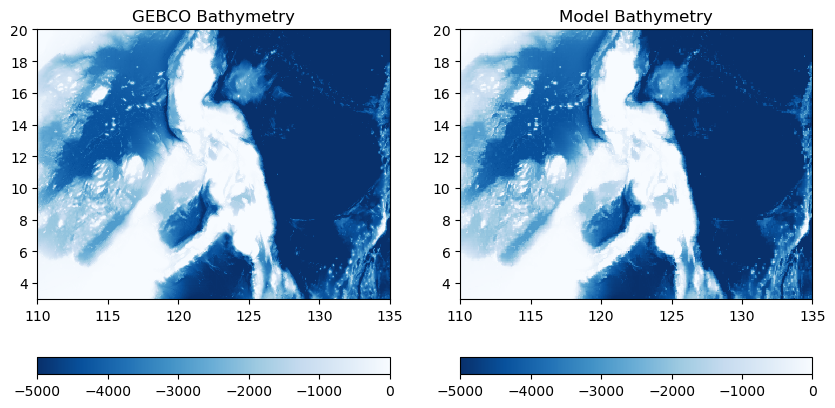

In [44]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(Gebco_Lon, Gebco_Lat, Gebco_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('GEBCO Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, Model_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

plt.show()

### Checking for isolated regions
One potential problem that can be encountered in ocean models occurs with isolated regions

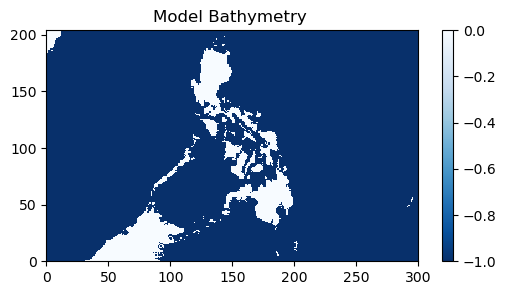

In [46]:
plt.figure(figsize=(6,3))

C = plt.pcolormesh(Model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry ')

plt.show()

As we can see, there are several isolated regions includes the San Francisco Bay and the Salton Sea. In addition, there is an area of extreme detail in the area of British Columbia, Canada. Before proceeding with the model, these regions need to be addressed.

Fortunately, Mike has written a tool to fill in these unconnected regions. You can clone his [eccoseas](https://github.com/mhwood/eccoseas) repository to access a tool related to this process. If you clone it in the current directory, you can use import it here:

In [47]:
from eccoseas.downscale import bathymetry as edb

With the tools imported, we can now use the `fill_unconnected_model_regions` to fill in these regions.

In [48]:
Model_bathy = edb.fill_unconnected_model_regions(Model_bathy, central_wet_row=100, central_wet_col=100)

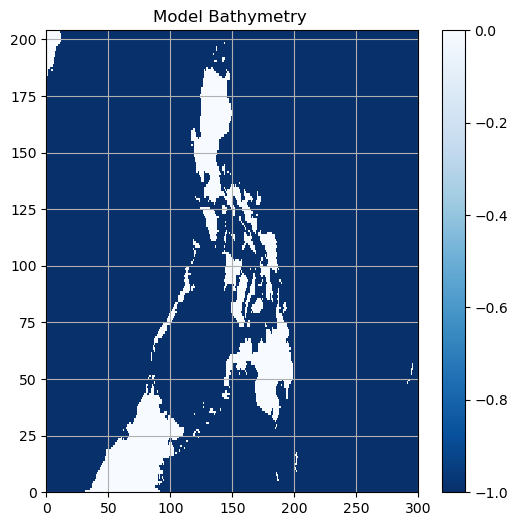

In [49]:
plt.figure(figsize=(6,3))

C = plt.pcolormesh(Model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.grid()
plt.title('Model Bathymetry ')

plt.show()

### Checking for problem areas
Another potential problem that can be encountered in ocean models occurs in regions where there is shallow bathymetry in enclosed bays. In these regions, there can be fast currents and strong dynamics. If this is your area of interest, then this is great! If not, it may cause problems in your domain. One option is to manually fill in these areas to avoid any potential issues. 

In this example, I will fill in the Juan de Fuca Strait between Canada and Washington State.

In [14]:
# fill in some areas around BC
Model_bathy_filled = np.copy(Model_bathy)
Model_bathy_filled[342:352, 85:105] = 0
Model_bathy_filled[282:340, 130:160] = 0
Model_bathy_filled[325:350, 115:130] = 0

Then, plot the filled bathymetry to ensure it looks as expected

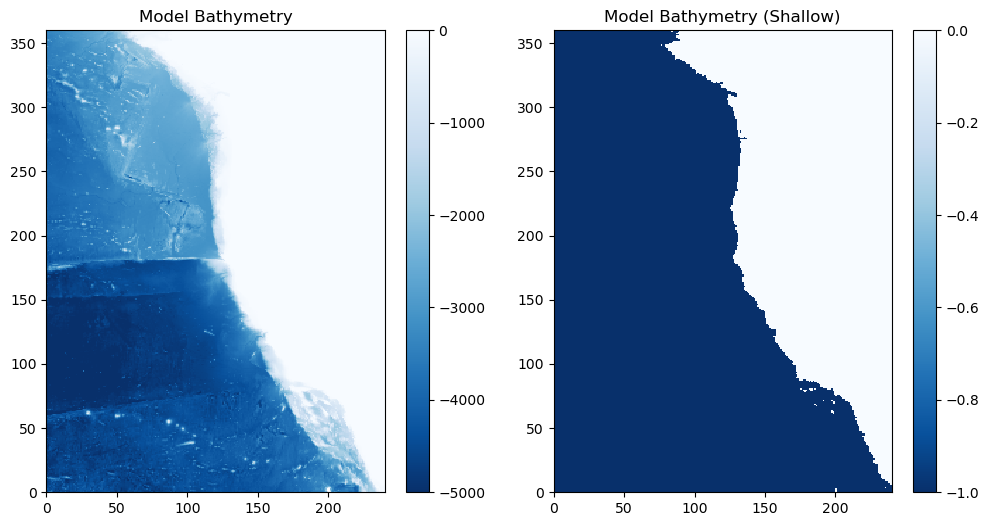

In [15]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
C = plt.pcolormesh(Model_bathy_filled, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(Model_bathy_filled, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry (Shallow)')

plt.show()

In [16]:
output_file = 'CA_bathymetry.bin'
Model_bathy_filled.ravel('C').astype('>f4').tofile(output_file)

This will be implemented into the model by editing the `PARM05` dataset of the `data` file as follows:
```
 &PARM05
 bathyFile = 'CA_bathymetry.bin,
 &
```